In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [2]:
df = pd.read_csv('Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
1044,@united well that's big of you but I don't hav...,negative
3792,@united Boeing 777 Star Alliance short finals ...,positive
7787,@JetBlue good to hear. Thx for being responsive.,positive
5275,@SouthwestAir no thanks,neutral
3557,@united @staralliance how can I book reward tr...,negative


In [3]:
sentiment_dict = {'negative':1, 'positive':2, 'neutral':0}

In [4]:
df['sentiment'] = df['airline_sentiment'].map(sentiment_dict)

In [5]:
df.drop(columns=['airline_sentiment'], inplace=True)
df.head()

,text,sentiment
4200,@united took this picture on Thursday. #awesom...,2
7256,"@JetBlue Didn't find out my flight for NY, sch...",1
8909,@JetBlue @JayVig YES! Great real-time example....,2
8341,@JetBlue Ever consider coming to Memphis? Nee...,0
3191,"@united enough already with the poor service, ...",1


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'],df['sentiment'], stratify=df['sentiment'])

# Build Model

In [7]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [8]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
hidden1 = tf.keras.layers.Dense(64, activation='sigmoid')(outputs['pooled_output'])
dropout1 = tf.keras.layers.Dropout(0.1, name="dropout")(hidden1)
hidden2 = tf.keras.layers.Dense(32, activation='sigmoid')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name="dropout2")(hidden2)
hidden3 = tf.keras.layers.Dense(16, activation='sigmoid')(dropout2)
l = tf.keras.layers.Dense(3, activation='softmax', name="output")(hidden3)

# l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [9]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training 

In [13]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=10, shuffle=True, callbacks=[early_stop])

Epoch 1/10
989/989 [==============================] - 2532s 3s/step - loss: 0.9246 - accuracy: 0.6190 - val_loss: 0.9004 - val_accuracy: 0.6403
Epoch 2/10
989/989 [==============================] - 2547s 3s/step - loss: 0.9190 - accuracy: 0.6255 - val_loss: 0.9009 - val_accuracy: 0.6403
Epoch 3/10
989/989 [==============================] - 2549s 3s/step - loss: 0.9183 - accuracy: 0.6255 - val_loss: 0.8966 - val_accuracy: 0.6403
Epoch 4/10
989/989 [==============================] - 2566s 3s/step - loss: 0.9186 - accuracy: 0.6255 - val_loss: 0.8963 - val_accuracy: 0.6403
Epoch 5/10
989/989 [==============================] - 2561s 3s/step - loss: 0.9186 - accuracy: 0.6255 - val_loss: 0.8959 - val_accuracy: 0.6403
Epoch 6/10
989/989 [==============================] - 2593s 3s/step - loss: 0.9175 - accuracy: 0.6255 - val_loss: 0.8955 - val_accuracy: 0.6403
Epoch 7/10
989/989 [==============================] - 2565s 3s/step - loss: 0.9166 - accuracy: 0.6255 - val_loss: 0.8983 - val_accuracy:

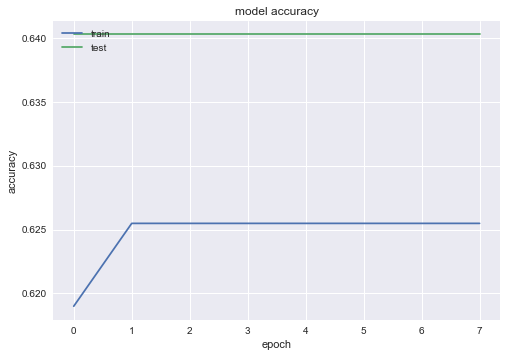

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

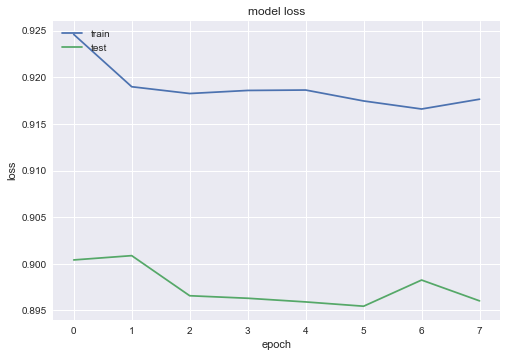

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evalulate

In [16]:
model.evaluate(X_test, y_test)

115/115 [==============================] - 813s 7s/step - loss: 0.9141 - accuracy: 0.6268


[0.9141409397125244, 0.6267759799957275]

# Test

In [17]:
reviews = [
    'very poor, turbulent',
    'amazing flight!',
    "i will never fly again!",
    "wish you flew to boston"

]
model.predict(reviews)

array([[0.20644058, 0.6352408 , 0.15831865],
       [0.20780818, 0.6325646 , 0.15962723],
       [0.2082353 , 0.63209474, 0.15967001],
       [0.20980795, 0.6273941 , 0.16279803]], dtype=float32)